In [25]:
import xgboost as xgb
from catboost import CatBoostClassifier, cv ,Pool
from catboost.utils import get_roc_curve, select_threshold
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
import hyperopt
import optuna
import shap

# Download data

In [2]:
data = pd.read_csv('./data/orange_small_churn_train_data.csv')

In [3]:
data.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Columns: 232 entries, ID to labels
dtypes: float64(192), int64(2), object(38)
memory usage: 32.4+ MB


In [5]:
# check disbalance in classes
print(data['labels'].value_counts())
print(data['labels'].unique())

-1.0    16921
 1.0     1377
Name: labels, dtype: int64
[-1.  1. nan]


In [6]:
data['labels'].replace(-1, 0, inplace=True)
data.dropna(subset=['labels'], inplace=True)
labels = data['labels']
data = data.iloc[:,:-1]

In [7]:
cat_boost_selecting_feature = ['Var126', 'Var113', 'Var199', 'Var57', 'Var202', 'Var74', 'Var218', 'Var73', 'Var205', 'Var81',
 'Var207', 'Var133', 'Var38', 'Var192', 'Var216', 'Var13', 'Var193', 'Var222', 'Var134', 'Var153', 'Var123', 'Var226', 'Var149',
 'Var210', 'Var206', 'Var212', 'Var219', 'Var204', 'Var125', 'Var28']

In [8]:
numeric_col = data.columns[1:190]
cat_col = data.columns[190:]
new_numeric = np.intersect1d(numeric_col, cat_boost_selecting_feature)
new_cat = np.intersect1d(cat_col, cat_boost_selecting_feature)

In [9]:
data_train = data[cat_boost_selecting_feature]

final training

In [10]:
train_data_boost, test_data_boost, train_label_boost, test_label_boost = train_test_split(data_train, labels,
                                                                                         test_size=0.3,random_state=42)

In [11]:
train_data_boost.fillna('NaN',inplace=True)
test_data_boost.fillna('NaN',inplace=True)

In [12]:
train_pool = Pool(train_data_boost, train_label_boost, cat_features=list(new_cat))
test_pool = Pool(test_data_boost, test_label_boost, cat_features=list(new_cat))

In [13]:
# old best params
best = {'depth': 4.0, 'l2_leaf_reg': 2.0, 'learning_rate': 0.286}
# new best params
#{'depth': 6.0, 'l2_leaf_reg': 14.0, 'learning_rate': 0.4702911427230305}

In [14]:
best_model = CatBoostClassifier(
                                l2_leaf_reg=int(best['l2_leaf_reg']),
                                learning_rate=best['learning_rate'],
                                depth = int(best['depth']),
                                iterations=100,
                                eval_metric='AUC',
                                loss_function='Logloss',
                                random_seed=42,
                                verbose=False,
                                use_best_model=True
                              )

In [15]:
best_model.fit(train_pool,
               eval_set =test_pool,
               verbose=False,
               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
fpr, tpr, thresholds = get_roc_curve(best_model, test_pool)

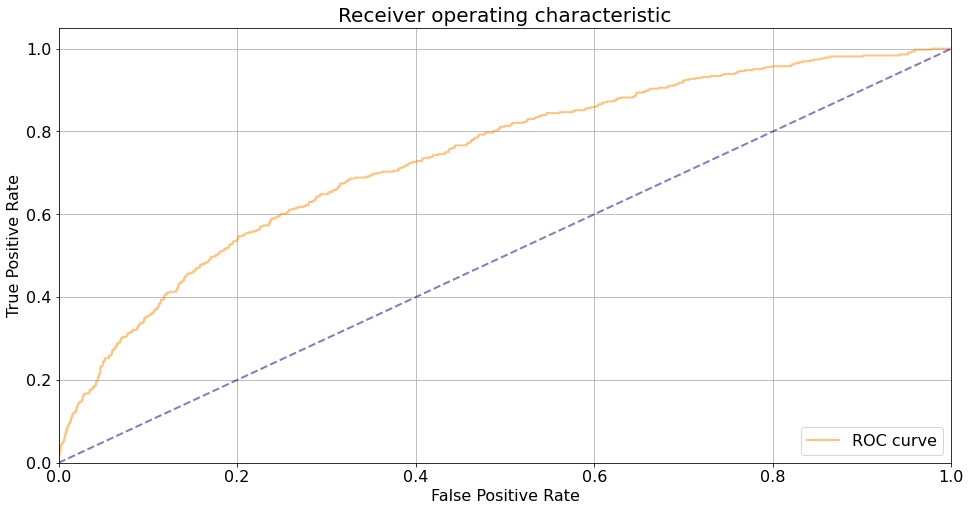

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve', alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [18]:
print(select_threshold(model=best_model, data=test_pool, FPR=0.01))

0.2962952873678003


In [19]:
def find_nearest_point(fpr, tpr, trsh):
    best_point = (0, 1)
    all_points = zip(fpr, tpr)
    distance = [np.linalg.norm(np.array(best_point) - np.array(point))for point in all_points]
    index_min = np.argmin(distance)
    return trsh[index_min], distance[index_min], fpr[index_min], tpr[index_min]

In [20]:
find_nearest_point(fpr, tpr, thresholds)


(0.06863441969113361,
 0.45290124383993036,
 0.32668772206869323,
 0.6863207547169812)

In [21]:
best_model.set_probability_threshold(0.6)

In [22]:
print(f'Recall: {recall_score(test_label_boost, best_model.predict(test_pool))}')
print(f'Precision: {precision_score(test_label_boost, best_model.predict(test_pool))}')
print(f'F1: {f1_score(test_label_boost, best_model.predict(test_pool))}')

Recall: 0.01179245283018868
Precision: 0.8333333333333334
F1: 0.023255813953488372


Shap value

In [26]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train_data_boost)

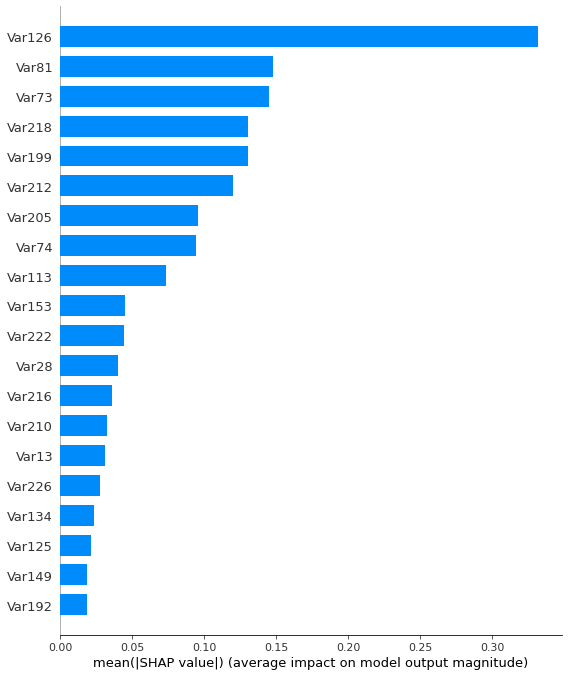

In [37]:
shap.summary_plot(shap_values, train_data_boost, plot_type='bar')

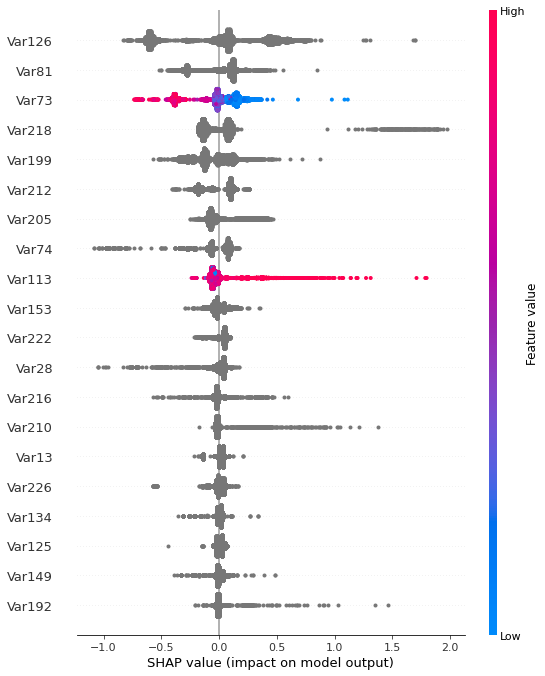

In [38]:
shap.summary_plot(shap_values, train_data_boost)